# Introduction

Dans ce TP on va explorer le monde du MLOps. Vous savez créer de modèles, les entrainer, utiliser des architectures avancées et plein de choses encore. 
Mais, pour pouvoir gérer au mieux vos modèles de Deep Learning, ainsi que vos différentes expériences, il faut avoir une organisation solide. 

Nous allons voir deux outils qui vont vous permettre de faire passer vos projets à la prochaine étape.

# Stockage des paramètres avec wandb

Commençons par créer un réseau très simple qui s'entraine sur MNIST 

epoch 0: loss 37.67017364501953
epoch 1: loss 25.84264373779297
epoch 2: loss 18.85115623474121
epoch 3: loss 15.049560546875
epoch 4: loss 12.506705284118652
epoch 5: loss 9.645100593566895
epoch 6: loss 6.685647010803223
epoch 7: loss 4.388463020324707
epoch 8: loss 3.16754150390625
epoch 9: loss 2.614088296890259


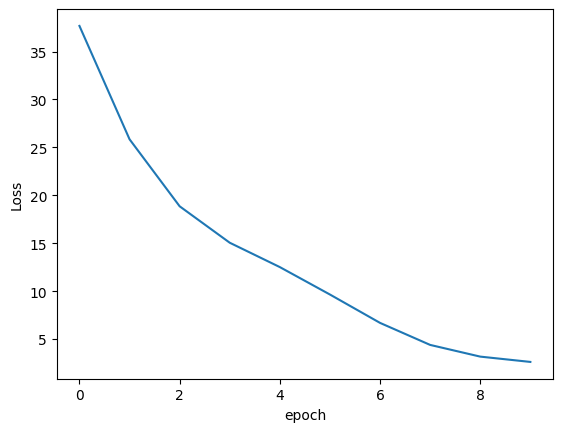

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Download and load the training data
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

# Download and load the test data
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())


# Define the model
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Train the model
epochs = 10
losses = []
for i in range(epochs):
    outputs = model.forward(train_dataset.data.view(-1, 784).float())
    loss = criterion(outputs, train_dataset.targets)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'epoch {i}: loss {loss}')

# Plot the loss
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()


Super ça marche ! Mais imaginez que vous voulez entrainer un modèle sur des centaines et des centaines d'epochs. Vous n'allez pas afficher un nombre à chaque fois sur votre pc ! Et puis ça serait cool si on pouvait avoir un graphe en temps réel de notre courbe de loss. 
Mieux encore, si on lancait notre petit script sur un cluster à distance, il faut qu'on puisse suivre quand même notre loss. 

C'est là que wandb intervient. Wandb vous permet de suivre vos expériences d'entrainement de manière très facile.

Pour se faire, il faut 

- Créer un compte ici :  https://wandb.ai/site  et se connecter
- Installer wandb avec pip (faites pip install wandb sur votre terminal)
- Ensuite, après avoir importer wandb faites wandb.login() et mettez votre token, disponible sur votre espace perso.

In [4]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fotiskapotos. Use `wandb login --relogin` to force relogin


True

Maintenant nous pouvons initialiser notre projet

In [5]:
run = wandb.init(
    # Nom du Projet
    project="my-awesome-project",
    # Sauvegarde des hyperparamètres
    config={
        "learning_rate": 0.001,
        "epochs": 10,
    })

Maintenant la seule chose que nous devons faire c'est utiliser wandb.log() pour entregistrer nos valeurs sur le projet ! 
Reprennnons notre boucle d'entraînement

In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Download and load the training data
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

# Download and load the test data
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())


# Define the model
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Train the model
epochs = 10
# losses = []
for i in range(epochs):
    outputs = model.forward(train_dataset.data.view(-1, 784).float())
    loss = criterion(outputs, train_dataset.targets)
    # losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # print(f'epoch {i}: loss {loss}')
    wandb.log({"loss": loss})




Vous pouvez maintenant aller sur le wandb. Vos données sont toutes là ! 
Des graphes ont été faits pour vous et vos paramètres sont sauvegardés. 

![Losses](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/image-hosting/TP8_Wandb/loss.png)

Vous pouvez lancer plusieurs expériences et avoir vos données sauvagardés sur le cloud ! 

Ceci eet bien évidemment qu'une toute petite partie de ce que lightning peut faire. N'hésitez pas à regarder la documentation pour en découvrir plus ! 

# Pytorch Lightning

Ecrire du code c'est bien, écrire du bon code c'est encore mieux ! 

Pytorch Lightning est une librairie de Python qui permet d'écrire du code pour du Deep Learning avec plus de simplicité.

Voyons comment ça marche ! 

In [2]:
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import lightning.pytorch as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch.nn.functional as F


In [1]:
# On définit le modèle type Lightning

# On log sur wandb
wandb_logger = WandbLogger()

# On crée un modèle de lighting
class LitModel(pl.LightningModule):
    def __init__(self):
        # On définit le modèle dans le init
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def training_step(self, batch):
        # On définit la fonction d'entrainement
        # Ici, pas besoin de faire de boucle, ni d'appeller zero_grad, ni optimize.step ni loss.backward
        x, y = batch
        y_hat = self.model(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs, target = batch
        y_hat = self.model(inputs)
        loss = F.cross_entropy(y_hat, target)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        # On définit l'optimizer 
        # TO DO return adam optimizer
        return ....
    
model = LitModel()
trainer = pl.Trainer(limit_train_batches=100, max_epochs=1, logger=wandb_logger) # Vous définissez votre trainer comme vous le souhaitez
trainer.fit(model=model, train_dataloaders=train_loader) # Vous lancez l'entrainement

SyntaxError: invalid syntax (3715345277.py, line 30)

Et là, lightning fait plein de choses pour vous ! Déjà vous n'avez pas à vous soucier de l'utilisation de GPU ou pas, lightning le fait pour vous ! 
Si vous voulez utilisez le gpu il suffit de mettre device = 1 dans le trainer

Ensuite, le logging est très facile et vous avez un joli résumé de vos paramètres au début. 

On vous laisse explorer plus en détail les fonctionalités fantastiques de lightning avec leur documentation

# Exercices

Pour vos défis, utilisez lighting pour créer vos modèles et wandb pour sauvegarder vos différents loss. Vous allez ainsi créer de modèle de plus en plus compliqués et vous allez decouvrir les fonctionalités plus avancés de lightning.